# Notebook for linear annealing with word dropout LSTM VAE

# Set up notebook

In [1]:
!nvidia-smi

Fri Jan  3 16:48:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 2.7MB/s 


# HUSK AT ÆNDRE ROOT PATH

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
#root_path = '/content/drive/My Drive/Colab Notebooks/Sentence_VAE/'
root_path = '/content/drive/My Drive/Sentence_VAE/'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Import modules

In [0]:
# import model
from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, get_latent_representation, getActiveUnits

In [0]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import sentencepiece as spm

import pickle
from IPython.display import Image, display, clear_output
import time

# Load data and SentencePiece model (See respective notebooks to see how they are made)

#### Load pickle with preprocessed data

In [0]:
#Small dataset
data_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))

In [22]:
print(f"train formal len: {len(data_dict['train']['formal'])}")
print(f"train informal len: {len(data_dict['train']['informal'])}")
print(f"test formal len: {len(data_dict['test']['formal'])}")
print(f"test informal len: {len(data_dict['test']['informal'])}")

#Large dataset
#from torch.utils.data import DataLoader
#training_data = data_dict["FR"]["train"]["formal"] + data_dict["FR"]["train"]["informal"] + data_dict["EM"]["train"]["formal"] + data_dict["EM"]["train"]["informal"]
#test_data = data_dict["FR"]["test"]["formal"] + data_dict["FR"]["test"]["informal"] + data_dict["EM"]["test"]["formal"] + data_dict["EM"]["test"]["informal"] 
#print("EM part")
#print(f"train formal len: {len(data_dict['EM']['train']['formal'])}")
#print(f"train informal len: {len(data_dict['EM']['train']['informal'])}")
#print(f"test formal len: {len(data_dict['EM']['test']['formal'])}")
#print(f"test informal len: {len(data_dict['EM']['test']['informal'])}")
#print("\nFR part")
#print(f"train formal len: {len(data_dict['FR']['train']['formal'])}")
#print(f"train informal len: {len(data_dict['FR']['train']['informal'])}")
#print(f"test formal len: {len(data_dict['FR']['test']['formal'])}")
#print(f"test informal len: {len(data_dict['FR']['test']['informal'])}")
#print("\nData sizes")
#print(f"training data len: {len(training_data)}")
#print(f"test data len: {len(test_data)}")

train formal len: 12824
train informal len: 12824
test formal len: 582
test informal len: 582


#### Load SentencePiece model

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'FRtraintest16000.model')
VOCAB_SIZE = 16000

#sp.Load(root_path + 'fulltraintest32000.model')
#VOCAB_SIZE = 32000

# Setting up model Model

### model

In [0]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
BATCH_SIZE = 2048
#BATCH_SIZE = 1024
SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25

#rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
#                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p = WORD_DROPOUT_P).cuda()

### Data loader

In [0]:
from torch.utils.data import DataLoader

#Small data 
training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
test_data_loader = DataLoader(test_data, batch_size=len(test_data))

#Large dataset

#training_data = data_dict['EM']['train']['formal'] + data_dict['EM']['train']['informal'] + data_dict['FR']['train']['formal'] + data_dict['FR']['train']['informal']
#train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

#test_data = data_dict['EM']['test']['formal'] + data_dict['FR']['test']['formal'] + data_dict['EM']['test']['informal'] + data_dict['FR']['test']['informal'] 
#test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)



### Optimizer

In [0]:
optimizer = optim.Adam(rnn_vae.parameters(),lr= 0.0006)

### Training and test functions

In [0]:
def train(epoch):
    rnn_vae.train()
    epoch_loss = 0
    epoch_bce = 0
    epoch_kld = 0
    for index, sentence in enumerate(train_data_loader):
        sentence = torch.LongTensor(sentence)
        sentence = sentence.cuda()
        optimizer.zero_grad()
        output, mu, logvar = rnn_vae.forward(sentence)
        loss, BCE, KLD = ELBO_lAnneal(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar, epoch=epoch, maxEpoch = 50)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_bce += BCE
        epoch_kld += KLD
    epoch_loss /= N_train
    epoch_bce /= N_train
    epoch_kld /= N_train
    return epoch_loss, epoch_bce, epoch_kld


def test(epoch):
    rnn_vae.eval()
    with torch.no_grad(): # No grads needed and we don't want to run out of mem
      epoch_loss = 0
      epoch_bce = 0
      epoch_kld = 0
      for index, sentence in enumerate(test_data_loader):
          sentence = torch.LongTensor(sentence)
          sentence = sentence.cuda()
          output, mu, logvar = rnn_vae.forward(sentence)
          loss, BCE, KLD = ELBO_lAnneal(recon_sentence=output.permute(0,2,1), sentence=sentence[:,1:], mu=mu, log_var=logvar, epoch=epoch, maxEpoch = 50)
          epoch_loss += loss.item()
          epoch_bce += BCE
          epoch_kld += KLD
      epoch_loss /= N_test
      epoch_bce /= N_test
      epoch_kld /= N_test
    return epoch_loss, epoch_bce, epoch_kld

## Training loop - RUN this rubrick, then the one below (to avoid time out of notebook)

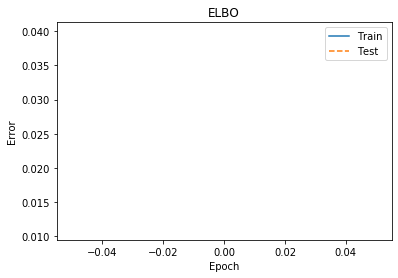

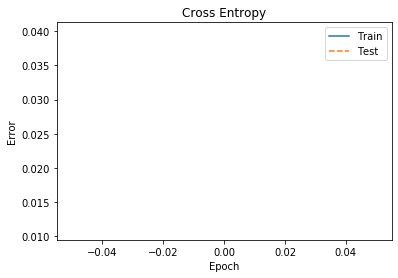

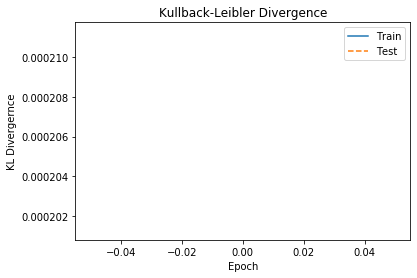

Epoch 0: time: 4.101853370666504
train: loss: 0.010943844328801184 BCE: 0.010943843051791191 KLD: 0.0002112555521307513
test: loss: 0.0398537809496483 BCE: 0.0398537814617157 KLD: 0.00020129529002588242


In [30]:
N_epochs = 2
N_train = len(training_data)
N_test = len(test_data)


train_loss_arr, train_bce_arr, train_kld_arr = [], [], []
test_loss_arr, test_bce_arr, test_kld_arr = [], [], []
for epoch in range(N_epochs//2):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

## run above rubrick first (runs for half of max epochs, then below runs for second half of max epochs)

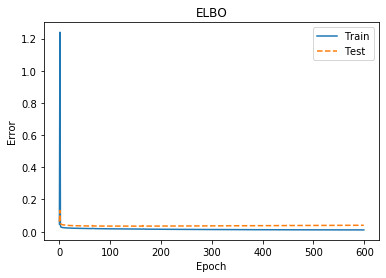

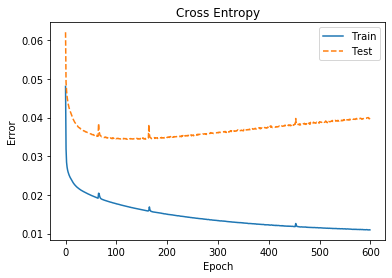

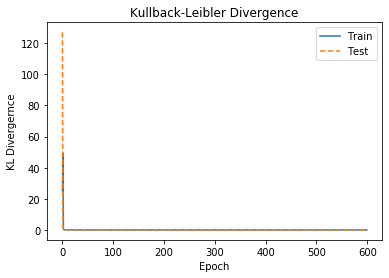

Epoch 599: time: 3.7793073654174805
train: loss: 0.010948194017725591 BCE: 0.01094808243215084 KLD: 0.00021891742653679103
test: loss: 0.039883154774039885 BCE: 0.03988298028707504 KLD: 0.00020129529002588242


In [14]:
for epoch in range(N_epochs//2, N_epochs):
    rnn_vae.train()
    start = time.time()

    train_loss, train_bce, train_kld = train(epoch)
    train_loss_arr.append(train_loss)
    train_bce_arr.append(train_bce)
    train_kld_arr.append(train_kld)

    test_loss, test_bce, test_kld = test(epoch)
    test_loss_arr.append(test_loss)
    test_bce_arr.append(test_bce)
    test_kld_arr.append(test_kld) 
    

    plot_loss(train_loss_arr, train_bce_arr, train_kld_arr,
              test_loss_arr, test_bce_arr, test_kld_arr)
    print(f"Epoch {epoch}: time: {time.time() - start}")
    print(f"train: loss: {train_loss} BCE: {train_bce} KLD: {train_kld}")
    print(f"test: loss: {test_loss} BCE: {test_bce} KLD: {test_kld}")
    clear_output(wait=True)

#### save model

In [0]:
torch.save(rnn_vae.state_dict(), root_path + "trained_models/" + "LA_WD_RNN_VAE_large_300epochs.pt")

#### Optional load model

In [29]:
rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=16000, seq_length=SEQ_LEN, word_dropout_p = WORD_DROPOUT_P).cuda()
rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "LA_WD_RNN_VAE_small.pt"))

<All keys matched successfully>

# Model evaluation

#### ELBO, CBE and KL Divergence of trained model

In [31]:
print(f"ELBO \nTrain: {train_loss_arr[-1]} Test: {test_loss_arr[-1]}")
print(f"Cross Entropy \nTrain: {train_bce_arr[-1]} Test: {test_bce_arr[-1]}")
print(f"KL Divergence \nTrain: {train_kld_arr[-1]} Test: {test_kld_arr[-1]}")

ELBO 
Train: 0.010943844328801184 Test: 0.0398537809496483
Cross Entropy 
Train: 0.010943843051791191 Test: 0.0398537814617157
KL Divergence 
Train: 0.0002112555521307513 Test: 0.00020129529002588242


# Get active units

In [32]:
active_units, test_vars = getActiveUnits(rnn_vae, test_data_loader, delta=0.02)
print(f"Active units: {active_units.cpu().numpy()}")
print(f"Variances: \n{test_vars.cpu().detach().numpy()}")

Active units: 0
Variances: 
[[4.0918626e-06 6.7728056e-06 6.1940264e-06 2.7376666e-06 3.3354811e-06
  7.2002704e-06 6.4309165e-06 5.6419872e-06 3.3378592e-06 1.9573013e-06
  2.5777636e-06 3.8216667e-06 6.6459525e-06 6.6374650e-06 2.2964532e-06
  6.5988083e-06 3.2504381e-06 4.0205418e-06 2.4264400e-06 3.9947836e-06
  2.3640616e-06 3.8793833e-06 3.7974291e-06 4.9104447e-06 3.2185096e-06
  2.8505776e-06 6.6375055e-06 3.6703375e-06 2.8546187e-06 2.6071173e-06
  4.5782499e-06 3.0958017e-06 3.0177380e-06 3.1089394e-06 2.6264916e-06
  3.7515501e-06 7.6922597e-06 3.7721666e-06 3.6382569e-06 3.1654979e-06
  2.9355697e-06 5.6067493e-06 3.0779709e-06 3.7282118e-06 5.7344369e-06
  3.0721653e-06 2.9022754e-06 3.6744341e-06 2.5679740e-06 3.7437408e-06
  2.8944542e-06 4.7426597e-06 1.8134920e-06 5.4139014e-06 3.4772206e-06
  3.3599140e-06 3.7823881e-06 6.7792471e-06 4.9787227e-06 3.1025006e-06
  2.3080165e-06 3.2644550e-06 4.0414434e-06 2.1422554e-06]]


#### reconstructing sentences from training set

In [0]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: this thime it is really over.
Generated sentence: it isn't a different in the future.

*******
Real sentence: smell of his penus.
Generated sentence: only if you make it looks.

*******
Real sentence: but i think action speaks better than words
Generated sentence: if not then i will have work.

*******
Real sentence: i wouldn't date mid eastern guys.
Generated sentence: ask yourself, again i believe that!

*******
Real sentence: what i want you to do .
Generated sentence: for example a shirt or sweat shirt.

*******
Real sentence: no excessive exclamation points.
Generated sentence: that is not good at it.

*******
Real sentence: god showed us his love through jesus christ!
Generated sentence: because your mom is smarter than you!

*******
Real sentence: please let me know if this helps.
Generated sentence: keep it out get on your girl.

*******
Real sentence: some men look better in pink than some women.
Generated sentence: i still call a daily.

*******
Real sentence: 

#### reconstructing sentences from test set

In [0]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=test_data_loader)
  print('*******')

Real sentence: are you posing a rhetorical question?
Generated sentence: the best friends thing you would do.

*******
Real sentence: i do not intend to be mean.
Generated sentence: he still walks by you a lot, though.

*******
Real sentence: ask him if you should go see a doctor.
Generated sentence: and be smart about it.

*******
Real sentence: also, i would like to try again.
Generated sentence: do we get married her?

*******
Real sentence: women are coomplicated.
Generated sentence: i realize that if it works like you.

*******
Real sentence: doing that does sound rather feminine.
Generated sentence: but i say whatever floats your boat!

*******
Real sentence: do i desire to be in love?
Generated sentence: do you think she is going out?

*******
Real sentence: that is if you truly adore them.
Generated sentence: maybe she has a girlfriend on.

*******
Real sentence: you should never allow a man to mistreat you.
Generated sentence: it defintely ups messed up.

*******
Real sentence